# 0. Conjunto de datos

In [12]:
import pandas as pd
import re
import numpy as np
from collections import Counter

https://www.kaggle.com/competitions/spooky-author-identification/data

In [13]:
data = pd.read_csv("spooky-author-identification/train.zip")
data["text"].map(len).describe()

count    19579.000000
mean       149.057408
std        106.800189
min         21.000000
25%         81.000000
50%        128.000000
75%        191.000000
max       4663.000000
Name: text, dtype: float64

In [14]:
X = data.text.values
y = data.author.values

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# 1. EDA

Veamos el tamaño de los distintos conjuntos que tenemos

In [16]:
print(f"En total tenemos {len(X)} frases")
print(f"El conjunto de entrenamiento tiene {len(X_train)} frases")
print(f"El conjunto de test tiene {len(X_test)} frases")


En total tenemos 19579 frases
El conjunto de entrenamiento tiene 14684 frases
El conjunto de test tiene 4895 frases


Como es habitual, centraremos nuestros análisis sobre el conjunto de entrenamiento (nuestra partición `X_train`) aunque nos referimos en varias ocasiones al conjunto completo (`X`)

Para llevar a cabo el EDA, tokenizaremos de la forma más simple posible, separando palabras y signos de puntutación. Después argumentaremos porque emplear este tokenizador tan básico puede tener sentido para la tarea que tenemos entre manos.

In [17]:
def tokenize_basic(X):
    """
    Tokenizador básico que separa palabras completas y signos de puntuación.
    Args:
        - X: iterador con las frases
    Values:
        - Lista con las frases tokenizadas
    """
    return [re.findall(r'\w+|[^\w\s]', sentence) for sentence in X]
    # return re.findall(r'\w+|[^\w\s]', sentence)


Veamos el tamaño de nuestro vocabulario

In [18]:
word_counter_train = Counter()
for tokens in tokenize_basic(X_train):
    word_counter_train.update(tokens)
print(f"En la partición de entrenamiento tenemos {len(word_counter_train)} tokens distintos")

En la partición de entrenamiento tenemos 24381 tokens distintos


In [19]:
word_counter = Counter()
for tokens in tokenize_basic(X):
    word_counter.update(tokens)
print(f"En el conjunto completo tenemos {len(word_counter)} tokens distintos")

En el conjunto completo tenemos 27503 tokens distintos


Esto significa que en la partición de entrenamiento tenemos 3122 que no están presentes en el conjunto de entrenamiento. Esto deberemos tenerlo en cuenta a la hora de construir el modelo.

Veamos cuales son los tokens más frecuentes en nuestro corpus

In [20]:
n_mas_frec = 21
tokens_mas_frec = sorted(word_counter.items(), key=lambda x: x[1], reverse=True)[:n_mas_frec]
tokens_mas_frec_train = sorted(word_counter_train.items(), key=lambda x: x[1], reverse=True)[:n_mas_frec]


print(tokens_mas_frec)
print(tokens_mas_frec_train)

[(',', 38220), ('the', 33344), ('of', 20873), ('.', 20075), ('and', 17427), ('to', 12652), ('I', 10806), ('a', 10383), ('in', 8843), ('was', 6615), ('that', 6259), (';', 5159), ('my', 5045), ('"', 4969), ('had', 4382), ('with', 4220), ('it', 3961), ('his', 3824), ('as', 3546), ('he', 3533), ("'", 3520)]
[(',', 28567), ('the', 24847), ('of', 15554), ('.', 14995), ('and', 12994), ('to', 9423), ('I', 8097), ('a', 7706), ('in', 6563), ('was', 4941), ('that', 4676), (';', 3887), ('my', 3737), ('"', 3693), ('had', 3317), ('with', 3162), ('it', 2957), ('his', 2913), ('he', 2724), ("'", 2619), ('as', 2596)]


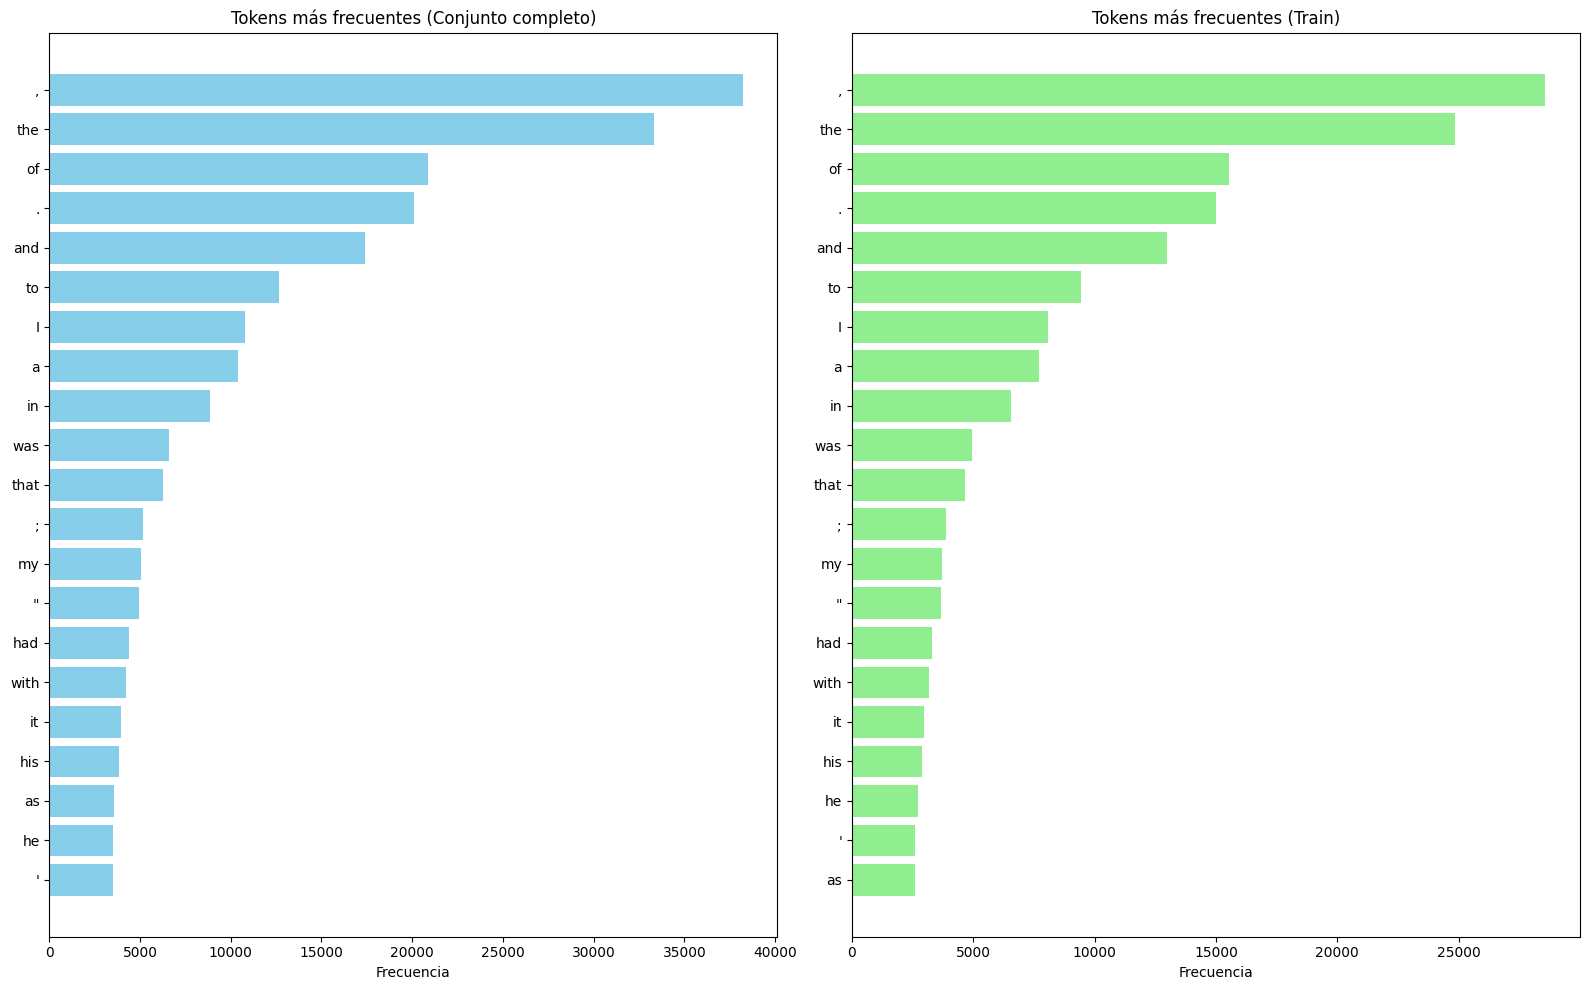

In [21]:
import matplotlib.pyplot as plt

# Obtener datos para el primero (general)
tokens1 = [item[0] for item in tokens_mas_frec]
frecs1 = [item[1] for item in tokens_mas_frec]

# Obtener datos para el segundo (train)
tokens2 = [item[0] for item in tokens_mas_frec_train]
frecs2 = [item[1] for item in tokens_mas_frec_train]

# Crear figura con 2 subplots horizontales
fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=False)

# Gráfico 1
axes[0].barh(tokens1[::-1], frecs1[::-1], color='skyblue')
axes[0].set_title('Tokens más frecuentes (Conjunto completo)')
axes[0].set_xlabel('Frecuencia')

# Gráfico 2
axes[1].barh(tokens2[::-1], frecs2[::-1], color='lightgreen')
axes[1].set_title('Tokens más frecuentes (Train)')
axes[1].set_xlabel('Frecuencia')

# Ajustar espacio
plt.tight_layout()
plt.show()

Vemos que los tokens más frecuentes todos *stop words* y signos de puntuación son salvo algunos pronombres y un verbo, lo cual era de esperar. Vemos además que la partición de entrenamiento es representativa del conjunto completo. De aquí en adelante nos referiremos solo a la partición de entrenamiento

Veamos la distribución de la variable objetivo

Text(0.5, 1.0, 'Número de muestras por autor')

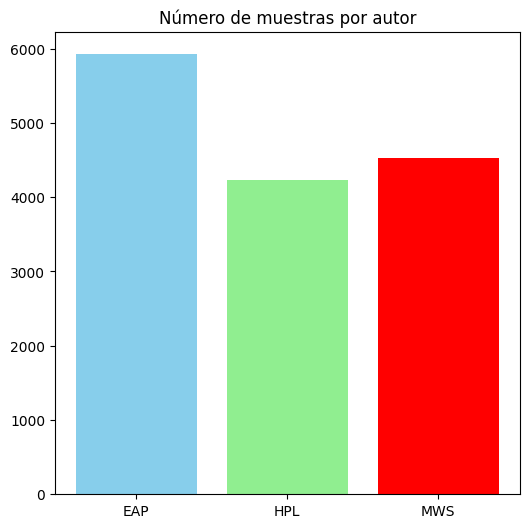

In [22]:
classes_count = np.unique(y_train,return_counts=True)
colors = ["skyblue","lightgreen","red"]

plt.figure(figsize=(6,6))
plt.bar(classes_count[0], classes_count[1], color=colors)
plt.title('Número de muestras por autor')

Observamos un pequeño desbalance entre las clases, pero que a priori no parece ser suficiente para requerir un tratemiento específico

Veamos los tokens más frecuentes en función del autor

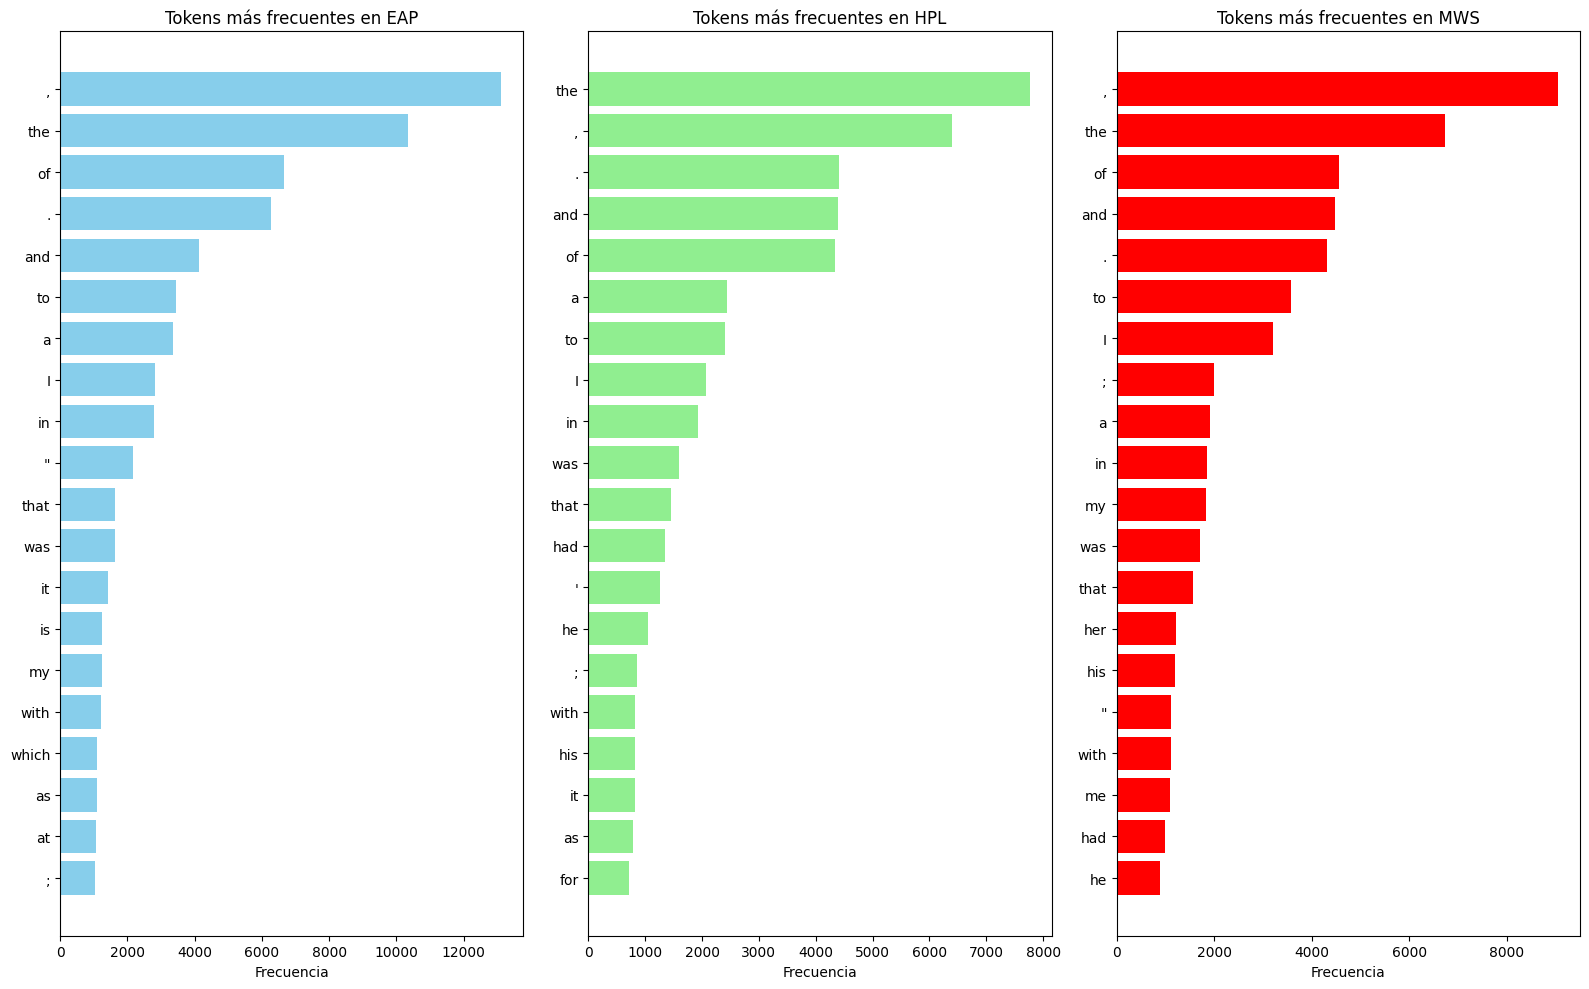

In [23]:
n_mas_frec = 20
fig, axes = plt.subplots(1, 3, figsize=(16, 10), sharey=False)


for i, autor in enumerate(np.unique(y_train)):

    # Filtramos por autor
    X_filtered = X_train[y_train == autor]

    # Creamos el contador
    word_counter = Counter()
    for tokens in tokenize_basic(X_filtered):
        word_counter.update(tokens)

    # Tokens más frecuentes
    tokens_mas_frec = sorted(word_counter.items(), key=lambda x: x[1], reverse=True)[:n_mas_frec]

    tokens = [item[0] for item in tokens_mas_frec]
    frecs = [item[1] for item in tokens_mas_frec]

   # Creamos el plot
  
    axes[i].barh(tokens[::-1], frecs[::-1], color=colors[i])
    axes[i].set_title(f'Tokens más frecuentes en {autor}')
    axes[i].set_xlabel('Frecuencia')

# Ajustar espacio
plt.tight_layout()
plt.show()

Vemos que en la muestra que tenemos, los 3 autores tienen tokenes más frecuentes muy similares. Tal vez el que se diferencia un poco más de los demás es EAP, aunque habría que hacer un análisis más exhaustivo para poder sustentar esta afirmación.

Para concluir este análisis, estudiemos la distribución de la longitud de las frases en función del autor

     min   mean  median  max
EAP    4  29.39    24.0  339
HPL    5  31.10    29.0  151
MWS    4  31.30    27.0  875


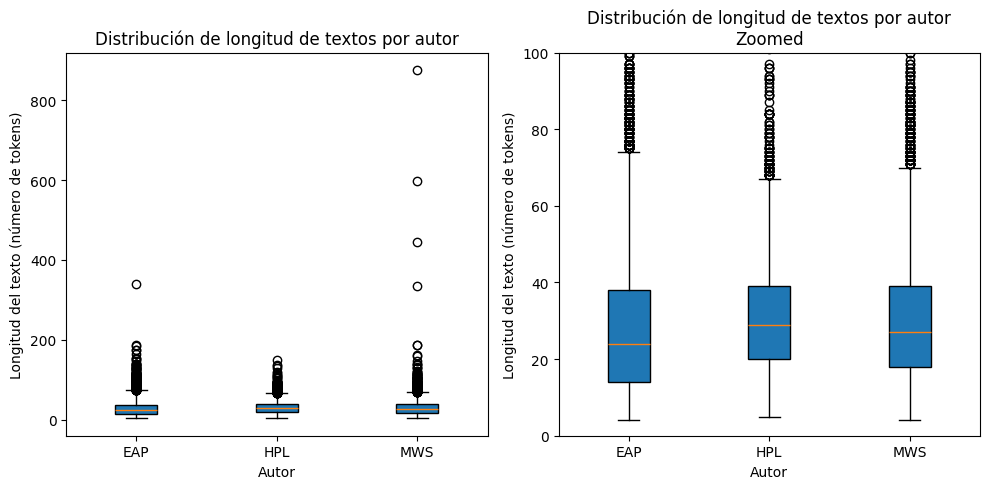

In [24]:
lengths = [len(s) for s in tokenize_basic(X_train)]
stats = []
lengths_autor = []
autores = np.unique(y_train)

for i, autor in enumerate(autores):

    # Longitudes por autor
    lengths_autor.append(np.array(lengths)[y_train == autor])

    # Estadísticas por autor
    stats.append({"min" : np.min(lengths_autor[i]),
                  "mean" : np.mean(lengths_autor[i]),
                  "median" : np.median(lengths_autor[i]),
                  "max" : np.max(lengths_autor[i])})
    
print(pd.DataFrame(stats, index = autores).round(2))

# Crear boxplot
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)
axes[0].boxplot(lengths_autor, tick_labels=autores, patch_artist=True,)
axes[0].set_title("Distribución de longitud de textos por autor")
axes[0].set_xlabel("Autor")
axes[0].set_ylabel("Longitud del texto (número de tokens)")

axes[1].boxplot(lengths_autor, tick_labels=autores, patch_artist=True)
axes[1].set_title("Distribución de longitud de textos por autor\nZoomed")
axes[1].set_xlabel("Autor")
axes[1].set_ylabel("Longitud del texto (número de tokens)")
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

Vemos que tenemos numerosos utiliers en la distribución de longitudes de frases. A pesar de eso, la distribución de las longitudes de las frases de cada autores son bastante similares. Además, dado que no sabemos cómo se han extraído las frases, no sabemos si los outliers son debidos al proceso de extracción de las frases o son característicos de los autores. Por ello, no será la longitud del texto no será una variable que nosotros empleemos directamente, ya que queremos que nuestro modelo generalice lo mejor posible.

# 2. Transformer from zero

Una vez ya conocemos nuestro conjunto de datos, el siguiente paso será abordar la tarea de clasificación que nos atañe: constuir un modelo capaz de diferenciar el autor dado un fragmento de texto de entre los tres que estamos considerando. Dado que no tenemos conocimientos expertos de estilometría (la rama de la lingüística que se encarga de estudiar los rasgos distintivos y patrones en el estilo de los autores) y no conocemos cuáles son las carácterísticas que deberíamos considerar para diferenciar a estos 3 autores, vamos a intentar constuir un sistema que aprenda de manera automática en qué características fijarse para diferenciarlos adoptando un enfoque computacional. Con tal fin emplearemos la arquitectura que ha revolucionado el procesamiento del lenguaje natural, el transformer. En realidad no usaremos la arquitectura completa (con módulo encoder y módulo decoder) ya que no estamos ante un problema seq2seq, si no ante un problema de clasificación de secuencias. Para ello, emplearemos un módulo encoder al que añadiremos una cabeza para hacer la clasificación.

Comenzaremos constuyendo el transforme completamente desde cero sin emplear nada preentrenado, los embeddings de los tokens también se aprenderán durante el entrenamiento. Emplearemos para ello la implementación vista en clase del encoder del transformer. 

Comenzaremos definiendo las clases que emplearemos para el embedding (de tokens y posicional) y para el bloque encoder del transformer

In [25]:
import keras
from keras import ops
from keras import layers 

# Clase para la capa de embedding (con embedidding posicional)
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        """
        Args:
            - maxlen: longitud máxima de la entrada 
            - vocab_size: tamaño del vocabulario
            - embed_dim: dimensión del embedding
        """
        super().__init__() 
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim) 
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
                                                                               

    def call(self, x):
        """
        Args: 
            - x: array bidimensional con los tokens codificados de cada frase
        """
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
# Clase para el bloque de encoder del transformer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        """
        Args:
            - embed_dim: dimensión de embedings
            - num_heads: número de cabezas de atención
            - ff_dim: número de neuronas en la capa densa
            - rate: dropout rate
        """

        super().__init__() 
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), 
             layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6) # epsilon es un término que se suma a la varianza para evitar divisiones por 0
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs) # Porque el att está pensado para hacer atención cruzada (toma de uno los q's y de la otra las k's y las v's). 
        attn_output = self.dropout1(attn_output)                                            
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

2025-05-29 17:07:32.986290: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-29 17:07:33.230179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748531253.322542    1089 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748531253.346683    1089 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-29 17:07:33.562455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Además de esto, necesitamos definir un encoder que transforme las listas de tokens en vectores numéricos, ya que nuestro embedding toma como entrada vectores de la forma [3, 4,5..] donde el 3 en la primera posición significa que el primer token de la secuencia es el tercer token de una lista de tokens ordenados, el segundo es el cuarto, el tercero el quinto... Hay que tener en cuenta que necesitamos poder limitar el tamaño del vocabulario y dar una token distintivo a las palabras que se encuentran fuera de nuestro vocabulario ([OOV]), ya que hemos visto que en el conjunto de test tenemos palabras que no se encuentran en el conjunto de entrenamiendo. Para hacer esto ordenaremos las palabras de nuestro corpus en función de su frecuencia de aparición. Además, podemos darle el tamaño máximo que queremos que tengan nuestras frases codificadas (*maxlen*) y que cuando nuestra frase sea más corta complete con un token especial ([PAD]). Entrenaremos el encoder sobre la partición de entrenamiento.

In [26]:
from keras.utils import pad_sequences

class token_encoder:

    def __init__(self,vocab_size = None, maxlen = None):
        self.vocab_size = vocab_size
        self.maxlen = maxlen
        self.token_encoder = None
        self.encoder = None
        

    def fit(self, X, return_encoder_dic=False):
        """ 
        Método para entrenar el encorder
        Args:
            - X: Iterador con las frases tokenizadas
            - return_encoder_dic: Devolver el diccionario del encoder
        """
        # Creamos el contador
        token_counter = Counter()
        for tokens in X:
            token_counter.update(tokens)
        
        if not self.vocab_size:
            self.vocab_size = len(token_counter) + 2
            verbose=False
        else:
            verbose = True
        

        limited_vocab = [k for k, _ in token_counter.most_common(self.vocab_size-2)]
        token_encoder = {w:i+2 for i,w in enumerate(limited_vocab)}
        
        # Estadísticas
        if verbose:
            n_words = sum(token_counter.values())
            n_words_limited = sum(token_counter[w] for w in limited_vocab)
            pct = n_words_limited/n_words*100
            print(f"Este vocab_size conserva un {np.round(pct,2)}% de las palabras (ocurrencias) del corpus")

        self.token_encoder = token_encoder

        if return_encoder_dic:
            return token_encoder


    def encode(self, X):
        """
        Método para codificar las frases
        Args: 
            - X: Iterador con las frases tokenizadas
        Values: 
            - Array de listas con las frases codificadas.
        """   
        # Codificamos con el diccionario teniendo en cuenta:
        # OOV = 1
        # PAD = 0
        X_enc = np.array([list([self.token_encoder.get(w,1) for w in s]) for s in X], dtype=object)

        # Padding de la longitud indicada
        if self.maxlen:
            X_enc = pad_sequences(X_enc, maxlen=self.maxlen, value=0)
        
        return X_enc

Veamos un ejemplo de como funciona el el encoder que hemos definido

In [27]:
X_train_tokenized = tokenize_basic(X_train)

encoder = token_encoder(vocab_size = 15000)
encoder.fit(X_train_tokenized)
X_encoded = encoder.encode(X_train_tokenized)

Este vocab_size conserva un 97.9% de las palabras (ocurrencias) del corpus


In [28]:
print("Frase original: ", X_train[0])
print("Frase tokenizada: ", X_train_tokenized[0])
print("Frase codificada: ", X_encoded[0])

Frase original:  "You have, of course, an accurate description of the letter?"
Frase tokenizada:  ['"', 'You', 'have', ',', 'of', 'course', ',', 'an', 'accurate', 'description', 'of', 'the', 'letter', '?', '"']
Frase codificada:  [15, 199, 37, 2, 4, 243, 2, 40, 4871, 1906, 4, 3, 534, 57, 15]


## 2.1. Base model
Con esto ya tenemos todas las piezas para armar un primer modelo básico

### Preprocessing

Comenzamos tokenizando y codificando los datos con las funciones que hemos definido. De nuestro análisis previo, decidimos tomar un *maxlen* de 70 y un *vocab_size* de 5000.

In [18]:
maxlen=70
vocab_size=5000

# Estadísticas 
pct = sum([l<70 for l in lengths])/len(lengths)*100
print(f"El {np.round(pct,2)}% de las frases tiene una longitud menor que el maxlen")

# Tokenizamos las frases del conjunto de entrenamiento y test
X_train_tokenized = tokenize_basic(X_train)
X_test_tokenized = tokenize_basic(X_test)


# Definimos y entrenamos el encoder con el conjunto de entrenamiento
encoder = token_encoder(vocab_size=vocab_size, maxlen=maxlen)
encoder.fit(X_train_tokenized)

# Codificamos las frases de los conjuntos de entrenamiento y test
X_train_encoded = encoder.encode(X_train_tokenized)
X_test_encoded = encoder.encode(X_test_tokenized)

El 96.05% de las frases tiene una longitud menor que el maxlen
Este vocab_size conserva un 90.6% de las palabras (ocurrencias) del corpus


Además, hay que codificar el target para que sea un vector numérico

In [19]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

### Model definition
Definimos el modelo básico

In [30]:
embed_dim = 32  # Tamaño del embedding para cada token
num_heads = 2  # Número de cabezas de atención
ff_dim = 32  # Tamaño de la capa densa en el bloque del transformer
rate = 0.1


inputs = layers.Input(shape=(maxlen,))
x = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x) # De aquí sale Z: una matriz donde cada fila es el vector de cada token enriquecido
x = layers.GlobalAveragePooling1D()(x) # Usamo GAP para reducir la dimensionalidad (Hace la media por filas) 
x = layers.Dropout(rate)(x)            # Otra opción: layers.flatten(), problema: aumenta mucho la dimensión
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(rate)(x)
outputs = layers.Dense(3, activation="softmax")(x) # Tendremos la probabilidad de cada una de las clases

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

NameError: name 'TokenAndPositionEmbedding' is not defined

Vemos que la gran mayoría de los parámetros del modelo vienen de la capa de embedding.

### Entrenamiento

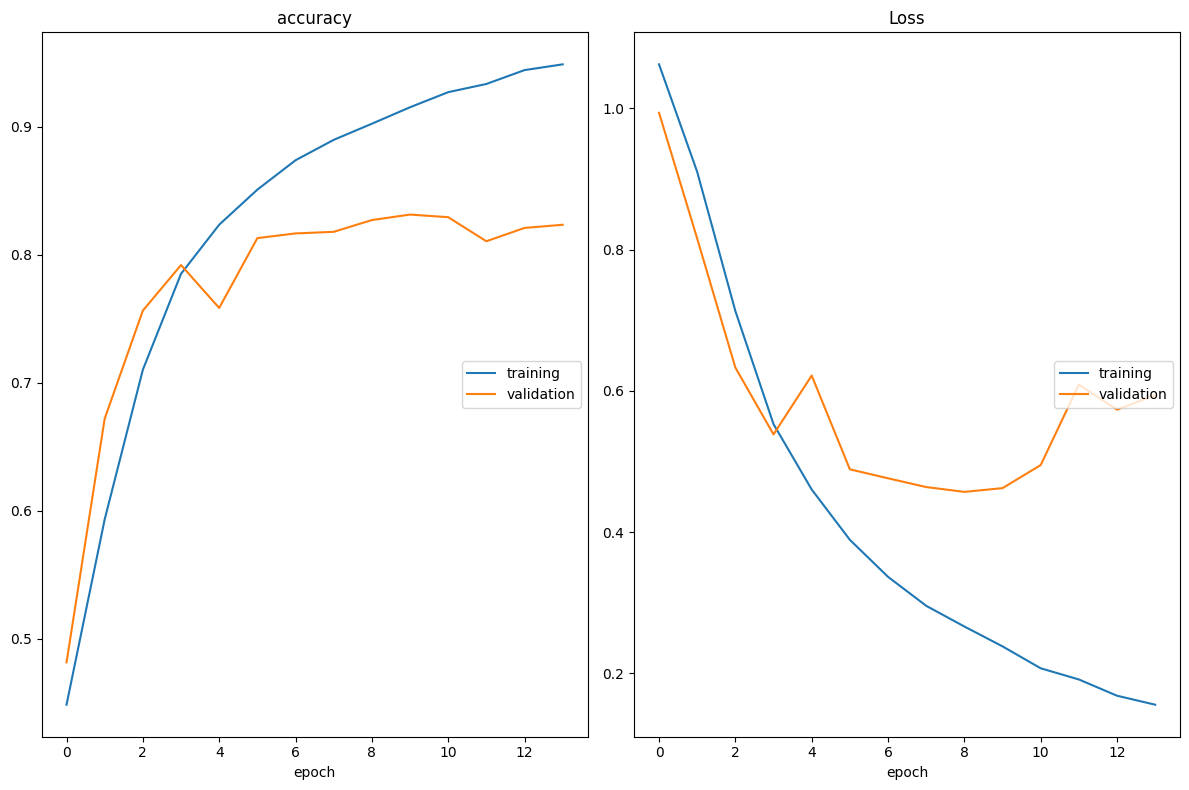

accuracy
	training         	 (min:    0.448, max:    0.949, cur:    0.949)
	validation       	 (min:    0.482, max:    0.831, cur:    0.823)
Loss
	training         	 (min:    0.156, max:    1.062, cur:    0.156)
	validation       	 (min:    0.457, max:    0.994, cur:    0.594)
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9506 - loss: 0.1532 - val_accuracy: 0.8233 - val_loss: 0.5939


In [48]:
from livelossplot import PlotLossesKerasTF

model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Definir el callback de Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=5,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

history = model.fit(
    X_train_encoded, 
    y_train_encoded, 
    batch_size=32, 
    epochs=15, 
    validation_data=(X_test_encoded, y_test_encoded), 
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

El modelo sobreajusta muy pronto. No tenemos suficientes datos para aprender un buen emedding y entrenar correctamente la capa de atención. El problema es complejo y requiere de más datos para poder aprender adecuadamente las características relevantes para la tarea. ¿Y si le damos un embedding ya entrenado?

### Evaluación

Vamos a ver el rendimiento del modelo sobre el conjunto test

In [ ]:
from sklearn.metrics import log_loss,accuracy_score

pred_probs = model.predict(X_test_encoded)
pred_class = ops.argmax(pred_probs,axis=1)
acc_test = ops.mean(pred_class == y_test_encoded)
m1_acc_test = accuracy_score(y_test_encoded,pred_class)
m1_log_loss_test = log_loss(y_test_encoded, pred_probs)

print("Accuracy en test: ", m1_acc_test)
print("Negative Cross-Entropy (Log Loss):", m1_log_loss_test)

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy en test:  0.8269662921348314
Negative Cross-Entropy (Log Loss): 0.4569245344340352


### Iteración
¿Y si le aumentamos el dropout y le dejamos solo una cabeza multiatención?

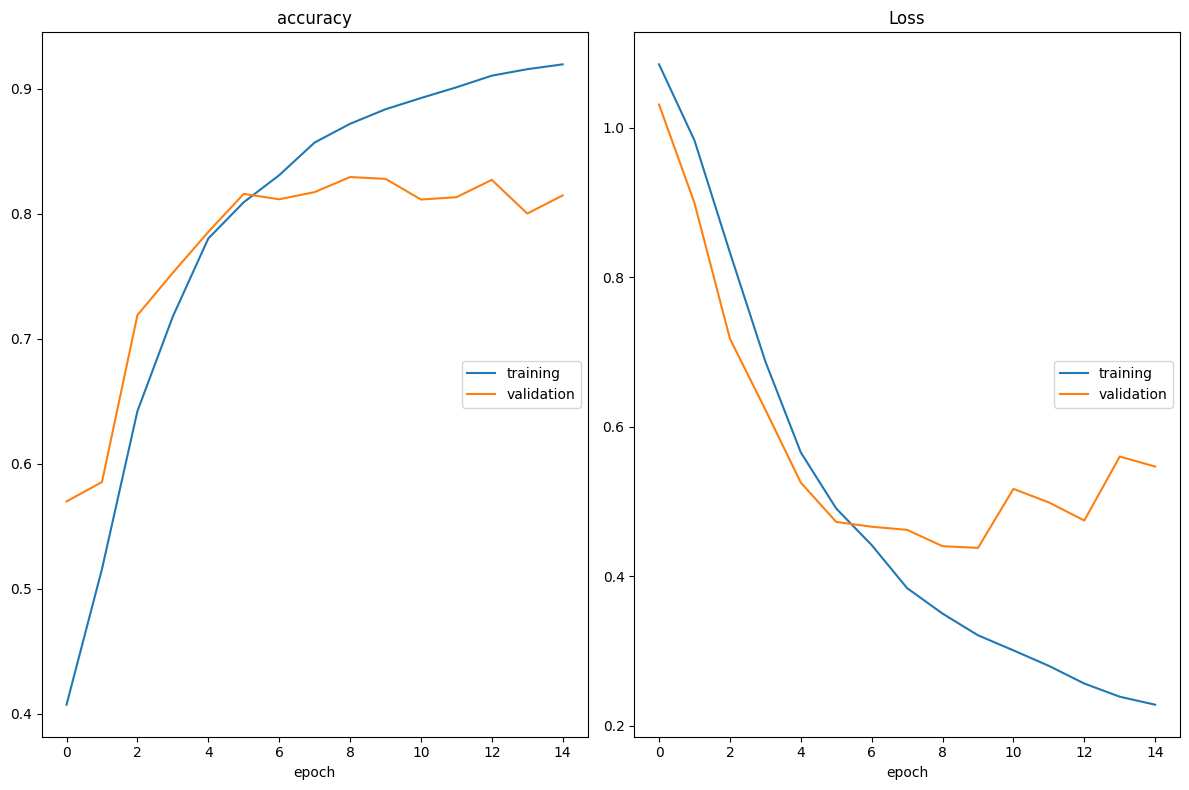

accuracy
	training         	 (min:    0.407, max:    0.920, cur:    0.920)
	validation       	 (min:    0.570, max:    0.829, cur:    0.815)
Loss
	training         	 (min:    0.228, max:    1.085, cur:    0.228)
	validation       	 (min:    0.438, max:    1.031, cur:    0.547)
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9222 - loss: 0.2251 - val_accuracy: 0.8147 - val_loss: 0.5467
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy en test:  0.8279877425944842
Negative Cross-Entropy (Log Loss): 0.4379868427360644


In [ ]:
### Definición
embed_dim = 32  # Tamaño del embedding para cada token
num_heads = 1  # Número de cabezas de atención
ff_dim = 32  # Tamaño de la capa densa en el bloque del transformer
rate = 0.3


inputs = layers.Input(shape=(maxlen,))
x = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x) # De aquí sale Z: una matriz donde cada fila es el vector de cada token enriquecido
x = layers.GlobalAveragePooling1D()(x) # Usamo GAP para reducir la dimensionalidad (Hace la media por filas) 
x = layers.Dropout(rate)(x)            # Otra opción: layers.flatten(), problema: aumenta mucho la dimensión
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(rate)(x)
outputs = layers.Dense(3, activation="softmax")(x) # Tendremos la probabilidad de cada una de las clases

model = keras.Model(inputs=inputs, outputs=outputs)

### Entrenamiento

model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Definir el callback de Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=5,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

history = model.fit(
    X_train_encoded, 
    y_train_encoded, 
    batch_size=32, 
    epochs=15, 
    validation_data=(X_test_encoded, y_test_encoded), 
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

### Evaluación
pred_probs = model.predict(X_test_encoded)
pred_class = ops.argmax(pred_probs,axis=1)
acc_test = ops.mean(pred_class == y_test_encoded)
m1_acc_test = accuracy_score(y_test_encoded,pred_class)
m1_log_loss_test = log_loss(y_test_encoded, pred_probs)

print("Accuracy en test: ", m1_acc_test)
print("Negative Cross-Entropy (Log Loss):", m1_log_loss_test)


Mejoramos un poco!! Pero persiste el problema del embedding

## 2.2. Different tokenizers

## 2.3. Hyperparameter tuning

## 2. Pretrained embedding

En el modelo base hemos visto que la mayor parte de parámetros entrenables están en la capa de embedding y eso es un problema, porque no tenemos un corpus suficiente para llegar a aprender buenos embeddings que capten el significado semántico de las palabras. Probablemente, esta sea una de las principales causas del sobre ajuste que observamos en el modelo. En un intento de darle solución, vamos a probar a darle unos embeddings ya aprendidos. Para el word embedding emplearemos GloVe, ya que revisando estudios similares es preferible a word2vec. Para el positional encoding vamos a emplear el embedding sinusoidal que usan en Atenttion is all you need. 

In [29]:
import gensim.downloader as api

# Cargamos el embedding pre-entrenado sobre la wikipedia
glove = api.load("glove-wiki-gigaword-300")
embedding_dim = glove.vector_size
print("La dimensión del embedding es:", embedding_dim)

La dimensión del embedding es: 300


In [30]:
vocab = {w.lower() for s in tokenize_basic(X) for w in s}

words_si = []

for w in vocab:
    if w in glove:
        words_si.append(w)
        
pct = len(words_si)/len(vocab)*100
print(f"GloVe contiene el {np.round(pct,2)}% de las palabras de nuestro vocabulario")

GloVe contiene el 89.64% de las palabras de nuestro vocabulario


Vemos que GloVe tiene el 90% de las palabras de nuestro vocabulario, por lo que podría servir. Las que no tenga, las pasaremos a [OOV]. **Ahora tenemos que pasar las palabras a minúsculas.**

In [31]:
# Vamos a cargar el diccionario del token_encoder para crear la matriz del embedding

X_train_pre = [s.lower() for s in X_train ]
X_train_tokenized = tokenize_basic(X_train_pre)

vocab_size = len(vocab)
# vocab_size = 14000

encoder = token_encoder(vocab_size= vocab_size, maxlen=70)
token_encoder_dic = encoder.fit(X_train_tokenized, return_encoder_dic=True)
X_encoded = encoder.encode(X_train_tokenized)
token_encoder_dic["[OOV]"] = 1
token_encoder_dic["[PAD]"] = 0

# Creamos la matriz del embedding a partir de la matriz de Glove empleando 
# nuestro vocabulario

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in token_encoder_dic.items():  # token_encoder maps word → index
    if word in glove:
        embedding_matrix[i] = glove[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))


Este vocab_size conserva un 100.0% de las palabras (ocurrencias) del corpus


Definimos una nueva clase para el hacer el embedding que emplee GloVe y el positional encoding sinusoidal. Esta vez queremos que sea fija, i.e. no entrenable.

In [32]:
import tensorflow as tf
import keras.layers as layers

class GloveWithFixedPositionalEncoding(layers.Layer):
    def __init__(self, vocab_size, maxlen, embedding_matrix):
        super().__init__()
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            trainable=False
        )
        self.maxlen = maxlen
        self.embed_dim = embedding_matrix.shape[1]
        self.pos_encoding = self.get_positional_encoding(maxlen, self.embed_dim)

    def get_positional_encoding(self, maxlen, embed_dim):
        angle_rads = self.get_angles(
            positions=tf.range(maxlen, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :],
            d_model=embed_dim
        )
        # Apply sin to even indices, cos to odd indices
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        return pos_encoding[tf.newaxis, ...]  # (1, maxlen, embed_dim)

    def get_angles(self, positions, i, d_model):
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return positions * angle_rates

    def call(self, x):
        x = self.token_emb(x)  # Shape: (batch_size, maxlen, embed_dim)
        x += self.pos_encoding[:, :tf.shape(x)[1], :]  # Add positional encoding
        return x

### Preprocesamiento
Repetimos el preprocesamiento que hicimos para el modelo anterior con una salvedad. Ahora tenemos que pasar todas las frases a minúscula.

In [33]:
from sklearn.preprocessing import LabelEncoder

maxlen=70

# Pasamos todas las frases a minúscula
X_train_pre = [s.lower() for s in X_train ]
X_test_pre = [s.lower() for s in X_test]

# Tokenizamos las frases del conjunto de entrenamiento y test
X_train_tokenized = tokenize_basic(X_train_pre)
X_test_tokenized = tokenize_basic(X_test_pre)


# Definimos y entrenamos el encoder con el conjunto de entrenamiento
encoder = token_encoder(maxlen=maxlen)
encoder.fit(X_train_tokenized)

# Codificamos las frases de los conjuntos de entrenamiento y test
X_train_encoded = encoder.encode(X_train_tokenized)
X_test_encoded = encoder.encode(X_test_tokenized)

# Hay que codificar la variable objetivo
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

### Definición del modelo

In [55]:
### Definición

embed_dim = embedding_matrix.shape[1]
num_heads = 2  # Número de cabezas de atención
ff_dim = embed_dim  # Tamaño de la capa densa en el bloque del transformer
rate = 0.5
maxlen = 70

inputs = layers.Input(shape=(maxlen,))
x =  GloveWithFixedPositionalEncoding(vocab_size, maxlen, embedding_matrix)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x) # De aquí sale Z: una matriz donde cada fila es el vector de cada token enriquecido
x = layers.GlobalAveragePooling1D()(x) # Usamo GAP para reducir la dimensionalidad (Hace la media por filas) 
x = layers.Dropout(rate)(x)            # Otra opción: layers.flatten(), problema: aumenta mucho la dimensión
x = layers.Dense(100, activation="relu")(x)
x = layers.Dropout(rate)(x)
outputs = layers.Dense(3, activation="softmax")(x) # Tendremos la probabilidad de cada una de las clases

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glove_with_fixed_positional_en… │ (None, 70, 300)        │     7,530,600 │
│ (GloveWithFixedPositionalEncod… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_14            │ (None, 70, 300)        │       903,900 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_11     │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,464,903 (32.29 MB)

 Trainable params: 934,303 (3.56 MB)

 Non-trainable params: 7,530,600 (28.73 MB)

### Entrenamiento

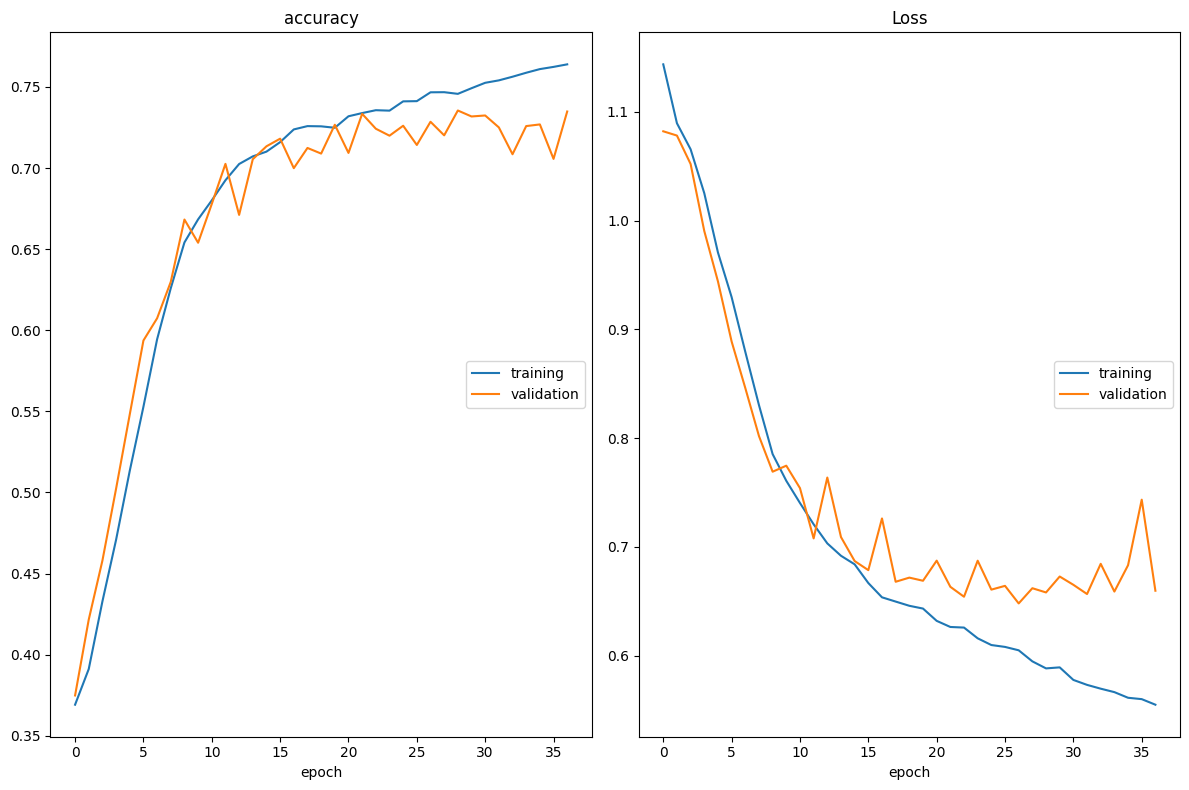

accuracy
	training         	 (min:    0.369, max:    0.764, cur:    0.764)
	validation       	 (min:    0.375, max:    0.735, cur:    0.735)
Loss
	training         	 (min:    0.555, max:    1.144, cur:    0.555)
	validation       	 (min:    0.648, max:    1.082, cur:    0.660)
459/459 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7677 - loss: 0.5512 - val_accuracy: 0.7348 - val_loss: 0.6597


In [56]:
### Entrenamiento

from livelossplot import PlotLossesKerasTF

model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Definir el callback de Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=10,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

history = model.fit(
    X_train_encoded, 
    y_train_encoded, 
    batch_size=32, 
    epochs=50, 
    validation_data=(X_test_encoded, y_test_encoded), 
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

### Evaluación

In [58]:
### Evaluación

# Predicciones
preds = model.predict(X_test_encoded)
pred_class = preds.argmax(axis=1)
preds_dec = encoder.inverse_transform(pred_class)

# Evaluación
report_glove= classification_report(y_test,preds_dec)
acc_glove= accuracy_score(y_test,preds_dec)
log_loss_glove= log_loss(y_test_encoded,preds)
print(report_glove)
print("Accuracy test:", np.round(acc_glove,2))
print("Log-loss test:", np.round(log_loss_glove,2))

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

         EAP       0.73      0.76      0.75      1975
         HPL       0.74      0.69      0.71      1409
         MWS       0.71      0.73      0.72      1511

    accuracy                           0.73      4895
   macro avg       0.73      0.72      0.73      4895
weighted avg       0.73      0.73      0.73      4895

Accuracy test: 0.73
Log-loss test: 0.65


- El rendimiento es peor que con el modelo base, lógico aquí tenemos muchos más parámetros entrenables lo que provoca que el sobreajuste se produzca antes. 
- El modelo sobreajusta muy pronto. Necesitamos reducir la dimensión de los embeddings, ya que esa es la causa de tener un número tan elevado de parámetros entrenables

## Iteración 1

Vamos a proyectar los embeddings en un espacio de dimensión inferior

In [41]:
embed_dim = 64
num_heads = 2  # Número de cabezas de atención
ff_dim = 64  # Tamaño de la capa densa en el bloque del transformer
rate = 0.5
maxlen = 70

inputs = layers.Input(shape=(maxlen,))
x =  GloveWithFixedPositionalEncoding(vocab_size, maxlen, embedding_matrix)(inputs)
x = layers.Dense(64, activation="relu")(x)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x) # De aquí sale Z: una matriz donde cada fila es el vector de cada token enriquecido
x = layers.GlobalAveragePooling1D()(x) # Usamo GAP para reducir la dimensionalidad (Hace la media por filas) 
x = layers.Dropout(rate)(x)            # Otra opción: layers.flatten(), problema: aumenta mucho la dimensión
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(rate)(x)
outputs = layers.Dense(3, activation="softmax")(x) # Tendremos la probabilidad de cada una de las clases

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glove_with_fixed_positional_en… │ (None, 70, 300)        │     7,530,600 │
│ (GloveWithFixedPositionalEncod… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 70, 64)         │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ (None, 70, 64)         │        41,792 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,592,747 (28.96 MB)

 Trainable params: 62,147 (242.76 KB)

 Non-trainable params: 7,530,600 (28.73 MB)

Hemos reducido drásticamente el número de parámetros. De casi 1M a 60k.

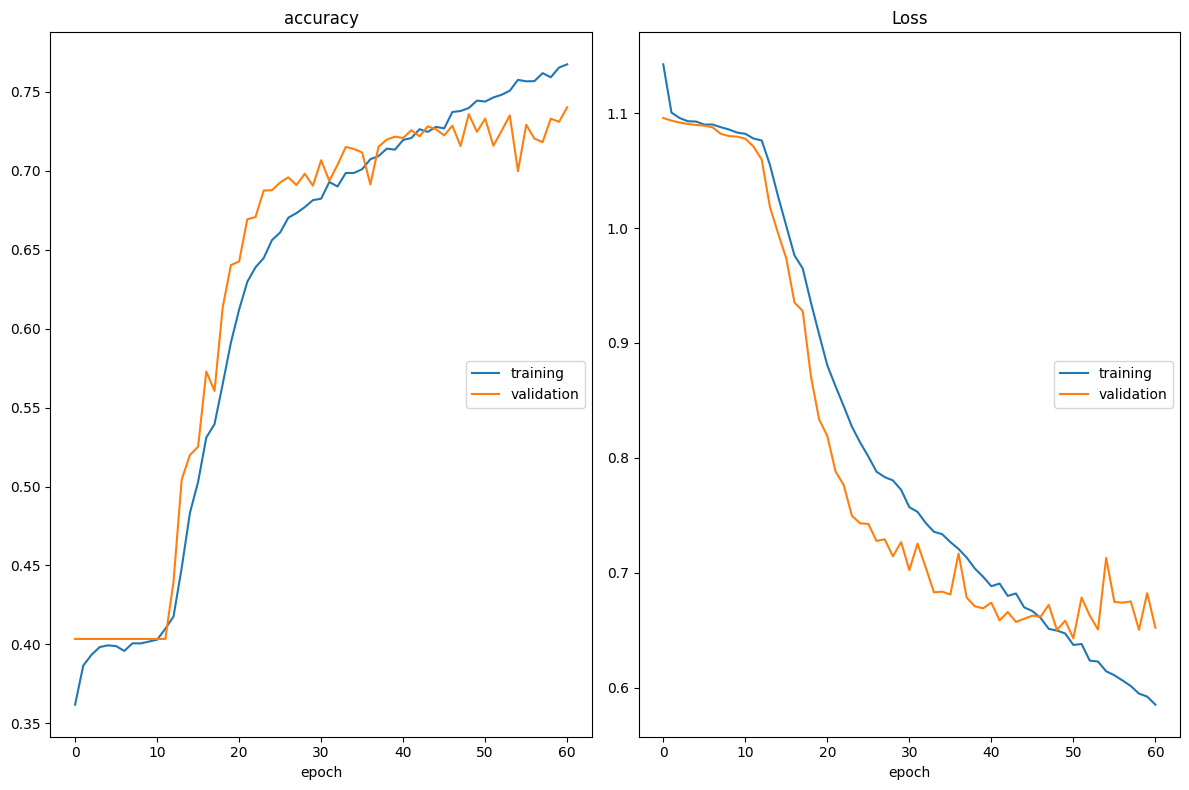

accuracy
	training         	 (min:    0.362, max:    0.767, cur:    0.767)
	validation       	 (min:    0.403, max:    0.740, cur:    0.740)
Loss
	training         	 (min:    0.585, max:    1.142, cur:    0.585)
	validation       	 (min:    0.643, max:    1.096, cur:    0.652)
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7668 - loss: 0.5904 - val_accuracy: 0.7401 - val_loss: 0.6523


In [42]:
from livelossplot import PlotLossesKerasTF

model.compile(
    optimizer= keras.optimizers.AdamW(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Definir el callback de Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=10,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

history = model.fit(
    X_train_encoded, 
    y_train_encoded, 
    batch_size=32, 
    epochs=100, 
    validation_data=(X_test_encoded, y_test_encoded), 
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

In [43]:
from sklearn.metrics import classification_report,log_loss,accuracy_score

# Predicciones
preds = model.predict(X_test_encoded)
pred_class = preds.argmax(axis=1)
preds_dec = encoder.inverse_transform(pred_class)

# Evaluación
report_glove= classification_report(y_test,preds_dec)
acc_glove= accuracy_score(y_test,preds_dec)
log_loss_glove= log_loss(y_test_encoded,preds)
print(report_glove)
print("Accuracy test:", np.round(acc_glove,2))
print("Log-loss test:", np.round(log_loss_glove,2))

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

         EAP       0.70      0.82      0.75      1975
         HPL       0.80      0.64      0.71      1409
         MWS       0.73      0.71      0.72      1511

    accuracy                           0.73      4895
   macro avg       0.74      0.72      0.73      4895
weighted avg       0.74      0.73      0.73      4895

Accuracy test: 0.73
Log-loss test: 0.64


El entrenamiento es muy lento y sobreajusta igualmente.

## Iteración 2
Vamos a reducir aún más la dimensión de los embeddings pero a aumentar el número de cabezas.

In [51]:
embed_dim = 32
num_heads = 8  # Número de cabezas de atención
ff_dim = 32  # Tamaño de la capa densa en el bloque del transformer
rate = 0.5
maxlen = 70

inputs = layers.Input(shape=(maxlen,))
x =  GloveWithFixedPositionalEncoding(vocab_size, maxlen, embedding_matrix)(inputs)
x = layers.Dense(32, activation="relu")(x)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x) # De aquí sale Z: una matriz donde cada fila es el vector de cada token enriquecido
x = layers.GlobalAveragePooling1D()(x) # Usamo GAP para reducir la dimensionalidad (Hace la media por filas) 
x = layers.Dropout(rate)(x)            # Otra opción: layers.flatten(), problema: aumenta mucho la dimensión
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(rate)(x)
outputs = layers.Dense(3, activation="softmax")(x) # Tendremos la probabilidad de cada una de las clases

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glove_with_fixed_positional_en… │ (None, 70, 300)        │     7,530,600 │
│ (GloveWithFixedPositionalEncod… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 70, 32)         │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_13            │ (None, 70, 32)         │        35,808 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_10     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,576,619 (28.90 MB)

 Trainable params: 46,019 (179.76 KB)

 Non-trainable params: 7,530,600 (28.73 MB)

Seguimos reduciendo el número de parámetros, ya menos de 50k.

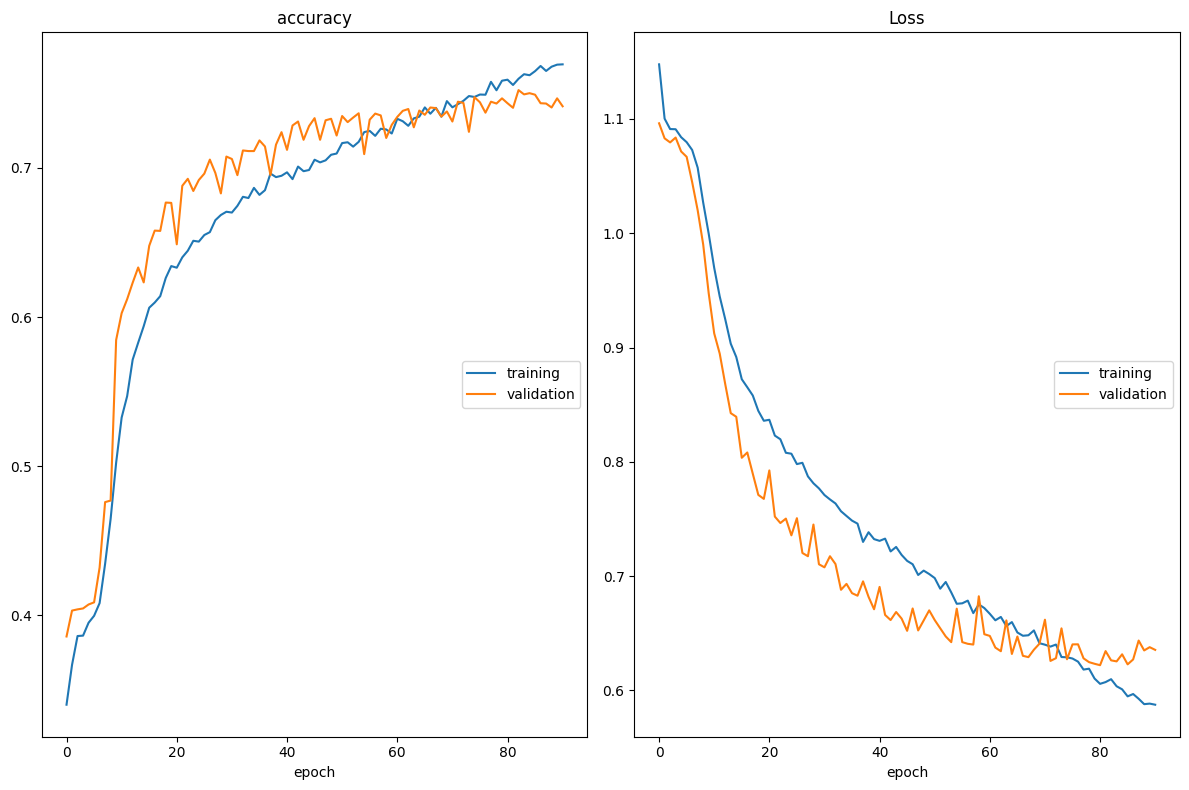

accuracy
	training         	 (min:    0.340, max:    0.769, cur:    0.769)
	validation       	 (min:    0.386, max:    0.752, cur:    0.741)
Loss
	training         	 (min:    0.587, max:    1.148, cur:    0.587)
	validation       	 (min:    0.622, max:    1.096, cur:    0.635)
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7693 - loss: 0.5923 - val_accuracy: 0.7414 - val_loss: 0.6354


In [52]:
from livelossplot import PlotLossesKerasTF

model.compile(
    optimizer= keras.optimizers.AdamW(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Definir el callback de Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=10,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

history = model.fit(
    X_train_encoded, 
    y_train_encoded, 
    batch_size=32, 
    epochs=100, 
    validation_data=(X_test_encoded, y_test_encoded), 
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

In [53]:
from sklearn.metrics import classification_report,log_loss,accuracy_score

# Predicciones
preds = model.predict(X_test_encoded)
pred_class = preds.argmax(axis=1)
preds_dec = encoder.inverse_transform(pred_class)

# Evaluación
report_glove= classification_report(y_test,preds_dec)
acc_glove= accuracy_score(y_test,preds_dec)
log_loss_glove= log_loss(y_test_encoded,preds)
print(report_glove)
print("Accuracy test:", np.round(acc_glove,2))
print("Log-loss test:", np.round(log_loss_glove,2))

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

         EAP       0.76      0.75      0.76      1975
         HPL       0.76      0.71      0.74      1409
         MWS       0.71      0.76      0.73      1511

    accuracy                           0.74      4895
   macro avg       0.74      0.74      0.74      4895
weighted avg       0.74      0.74      0.74      4895

Accuracy test: 0.74
Log-loss test: 0.62


## Iteración 3
Una sola cabeza

In [59]:
embed_dim = 32
num_heads = 1  # Número de cabezas de atención
ff_dim = 32  # Tamaño de la capa densa en el bloque del transformer
rate = 0.5
maxlen = 70

inputs = layers.Input(shape=(maxlen,))
x =  GloveWithFixedPositionalEncoding(vocab_size, maxlen, embedding_matrix)(inputs)
x = layers.Dense(32, activation="relu")(x)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x) # De aquí sale Z: una matriz donde cada fila es el vector de cada token enriquecido
x = layers.GlobalAveragePooling1D()(x) # Usamo GAP para reducir la dimensionalidad (Hace la media por filas) 
x = layers.Dropout(rate)(x)            # Otra opción: layers.flatten(), problema: aumenta mucho la dimensión
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(rate)(x)
outputs = layers.Dense(3, activation="softmax")(x) # Tendremos la probabilidad de cada una de las clases

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_30 (InputLayer)     │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glove_with_fixed_positional_en… │ (None, 70, 300)        │     7,530,600 │
│ (GloveWithFixedPositionalEncod… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 70, 32)         │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_15            │ (None, 70, 32)         │         6,464 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_12     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,547,275 (28.79 MB)

 Trainable params: 16,675 (65.14 KB)

 Non-trainable params: 7,530,600 (28.73 MB)

Seguimos reduciendo el número de parámetros, ya menos de 50k.

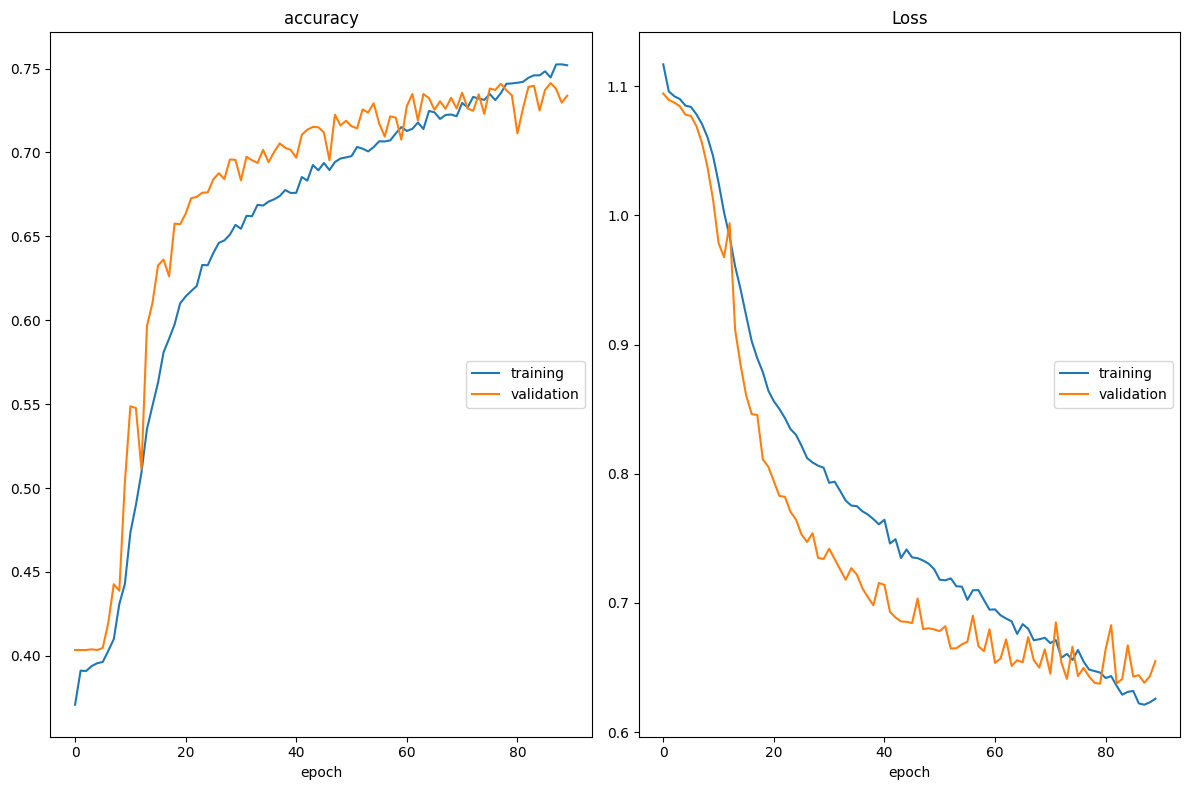

accuracy
	training         	 (min:    0.371, max:    0.753, cur:    0.752)
	validation       	 (min:    0.403, max:    0.741, cur:    0.734)
Loss
	training         	 (min:    0.621, max:    1.117, cur:    0.626)
	validation       	 (min:    0.637, max:    1.094, cur:    0.655)
459/459 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7514 - loss: 0.6285 - val_accuracy: 0.7338 - val_loss: 0.6549


In [60]:
from livelossplot import PlotLossesKerasTF

model.compile(
    optimizer= keras.optimizers.AdamW(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Definir el callback de Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=10,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

history = model.fit(
    X_train_encoded, 
    y_train_encoded, 
    batch_size=32, 
    epochs=100, 
    validation_data=(X_test_encoded, y_test_encoded), 
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

In [62]:
from sklearn.metrics import classification_report,log_loss,accuracy_score

# Predicciones
preds = model.predict(X_test_encoded)
pred_class = preds.argmax(axis=1)
preds_dec = encoder.inverse_transform(pred_class)

# Evaluación
report_glove= classification_report(y_test,preds_dec)
acc_glove= accuracy_score(y_test,preds_dec)
log_loss_glove= log_loss(y_test_encoded,preds)
print(report_glove)
print("Accuracy test:", np.round(acc_glove,2))
print("Log-loss test:", np.round(log_loss_glove,2))

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

         EAP       0.72      0.78      0.75      1975
         HPL       0.80      0.67      0.73      1409
         MWS       0.71      0.74      0.72      1511

    accuracy                           0.73      4895
   macro avg       0.74      0.73      0.73      4895
weighted avg       0.74      0.73      0.73      4895

Accuracy test: 0.73
Log-loss test: 0.64


### Iteración 4
Más pequeño, más cabezas

In [44]:
embed_dim = 8
num_heads = 8  # Número de cabezas de atención
ff_dim = 8  # Tamaño de la capa densa en el bloque del transformer
rate = 0.5
maxlen = 70

inputs = layers.Input(shape=(maxlen,))
x =  GloveWithFixedPositionalEncoding(vocab_size, maxlen, embedding_matrix)(inputs)
x = layers.Dense(embed_dim, activation="relu")(x)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x) # De aquí sale Z: una matriz donde cada fila es el vector de cada token enriquecido
x = layers.GlobalAveragePooling1D()(x) # Usamo GAP para reducir la dimensionalidad (Hace la media por filas) 
x = layers.Dropout(rate)(x)            # Otra opción: layers.flatten(), problema: aumenta mucho la dimensión
outputs = layers.Dense(3, activation="softmax")(x) # Tendremos la probabilidad de cada una de las clases

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glove_with_fixed_positional_en… │ (None, 70, 300)        │     7,530,600 │
│ (GloveWithFixedPositionalEncod… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 70, 8)          │         2,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ (None, 70, 8)          │         2,424 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,535,459 (28.75 MB)

 Trainable params: 4,859 (18.98 KB)

 Non-trainable params: 7,530,600 (28.73 MB)

Seguimos reduciendo el número de parámetros, ya menos de 50k.

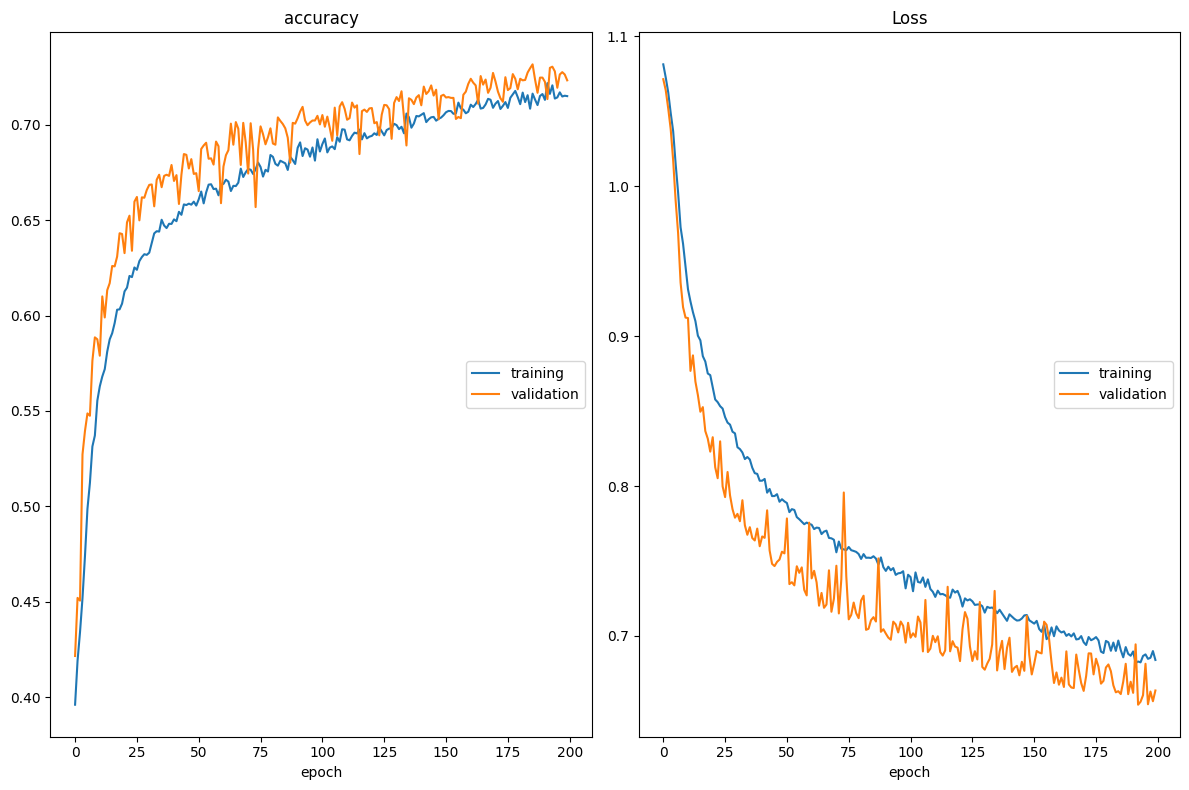

accuracy
	training         	 (min:    0.396, max:    0.722, cur:    0.715)
	validation       	 (min:    0.422, max:    0.732, cur:    0.723)
Loss
	training         	 (min:    0.682, max:    1.081, cur:    0.684)
	validation       	 (min:    0.654, max:    1.072, cur:    0.664)
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7138 - loss: 0.6845 - val_accuracy: 0.7232 - val_loss: 0.6635


In [46]:
from livelossplot import PlotLossesKerasTF

model.compile(
    optimizer= keras.optimizers.AdamW(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Definir el callback de Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=20,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

history = model.fit(
    X_train_encoded, 
    y_train_encoded, 
    batch_size=32, 
    epochs=200, 
    validation_data=(X_test_encoded, y_test_encoded), 
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

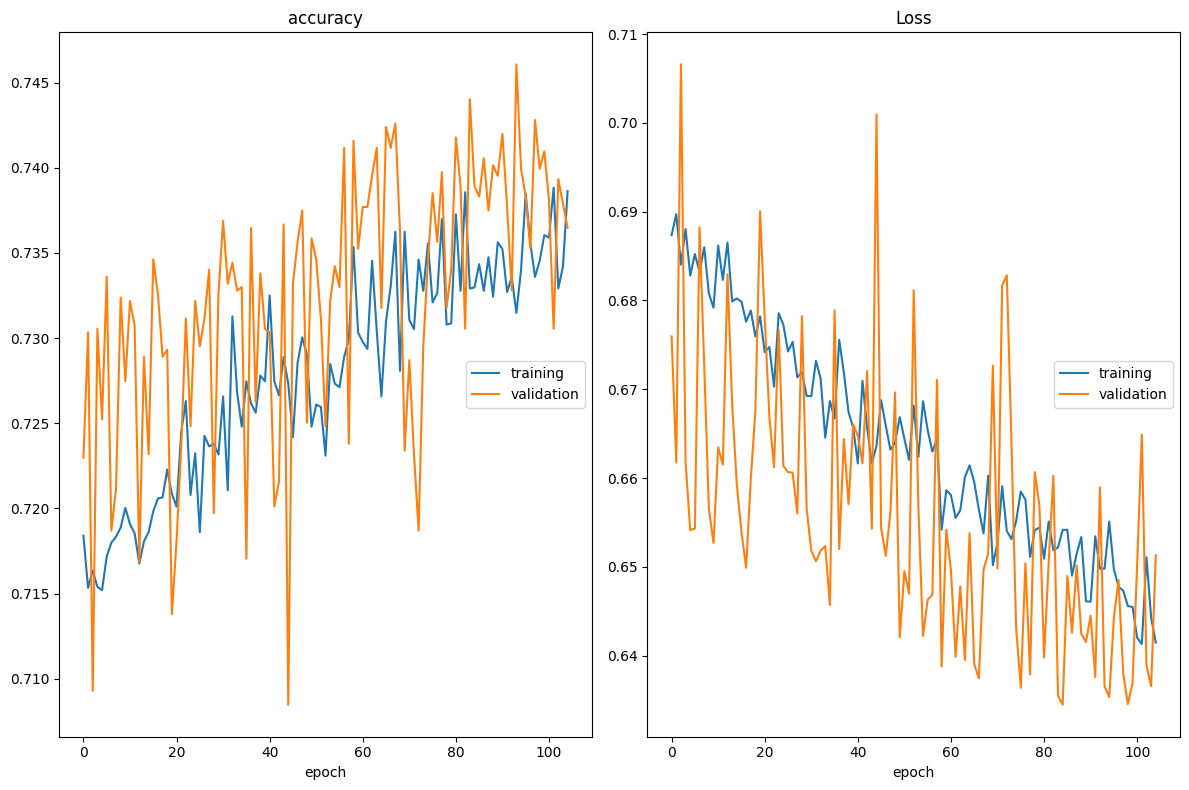

accuracy
	training         	 (min:    0.715, max:    0.739, cur:    0.739)
	validation       	 (min:    0.708, max:    0.746, cur:    0.736)
Loss
	training         	 (min:    0.641, max:    0.690, cur:    0.641)
	validation       	 (min:    0.634, max:    0.707, cur:    0.651)
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7371 - loss: 0.6444 - val_accuracy: 0.7365 - val_loss: 0.6513


In [48]:
history = model.fit(
    X_train_encoded, 
    y_train_encoded, 
    batch_size=32, 
    epochs=200, 
    validation_data=(X_test_encoded, y_test_encoded), 
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

In [49]:
from sklearn.metrics import classification_report,log_loss,accuracy_score

# Predicciones
preds = model.predict(X_test_encoded)
pred_class = preds.argmax(axis=1)
preds_dec = encoder.inverse_transform(pred_class)

# Evaluación
report_glove= classification_report(y_test,preds_dec)
acc_glove= accuracy_score(y_test,preds_dec)
log_loss_glove= log_loss(y_test_encoded,preds)
print(report_glove)
print("Accuracy test:", np.round(acc_glove,2))
print("Log-loss test:", np.round(log_loss_glove,2))

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

         EAP       0.72      0.81      0.76      1975
         HPL       0.77      0.68      0.72      1409
         MWS       0.74      0.71      0.72      1511

    accuracy                           0.74      4895
   macro avg       0.74      0.73      0.74      4895
weighted avg       0.74      0.74      0.74      4895

Accuracy test: 0.74
Log-loss test: 0.63


### Iteración 2: PCA
Probamos a usar PCA para reducir la matriz del embedding

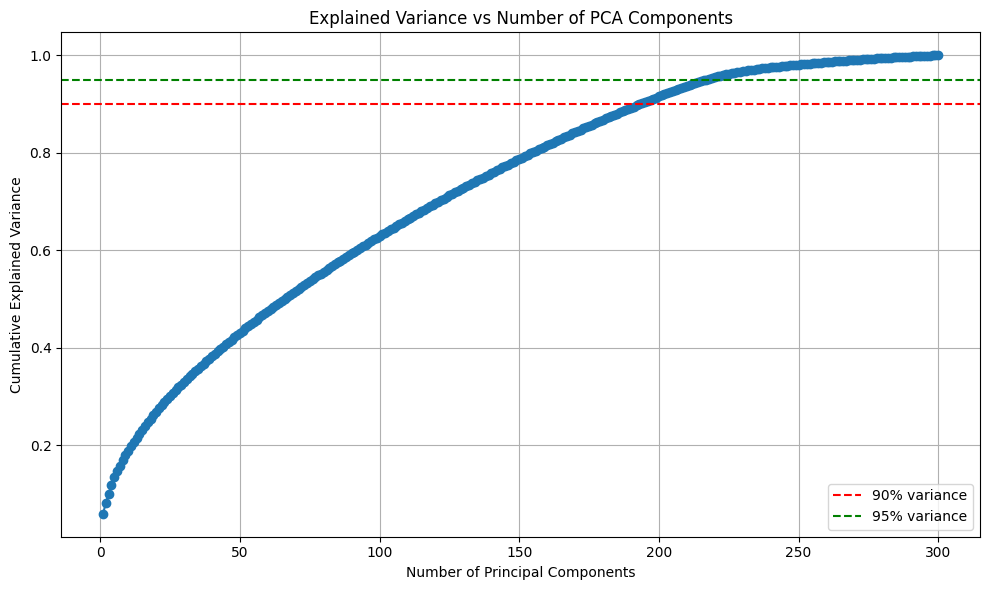

In [68]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Apply PCA
pca = PCA(n_components=300)
pca.fit(embedding_matrix)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of PCA Components')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


No parece que vaya a funcionar demasiado bien, pues la gráfica que observamos es muy lineal. Necesitaríamos una dimensión de 200 para explicar el 90% de la varianza. Probemos de todas formas.

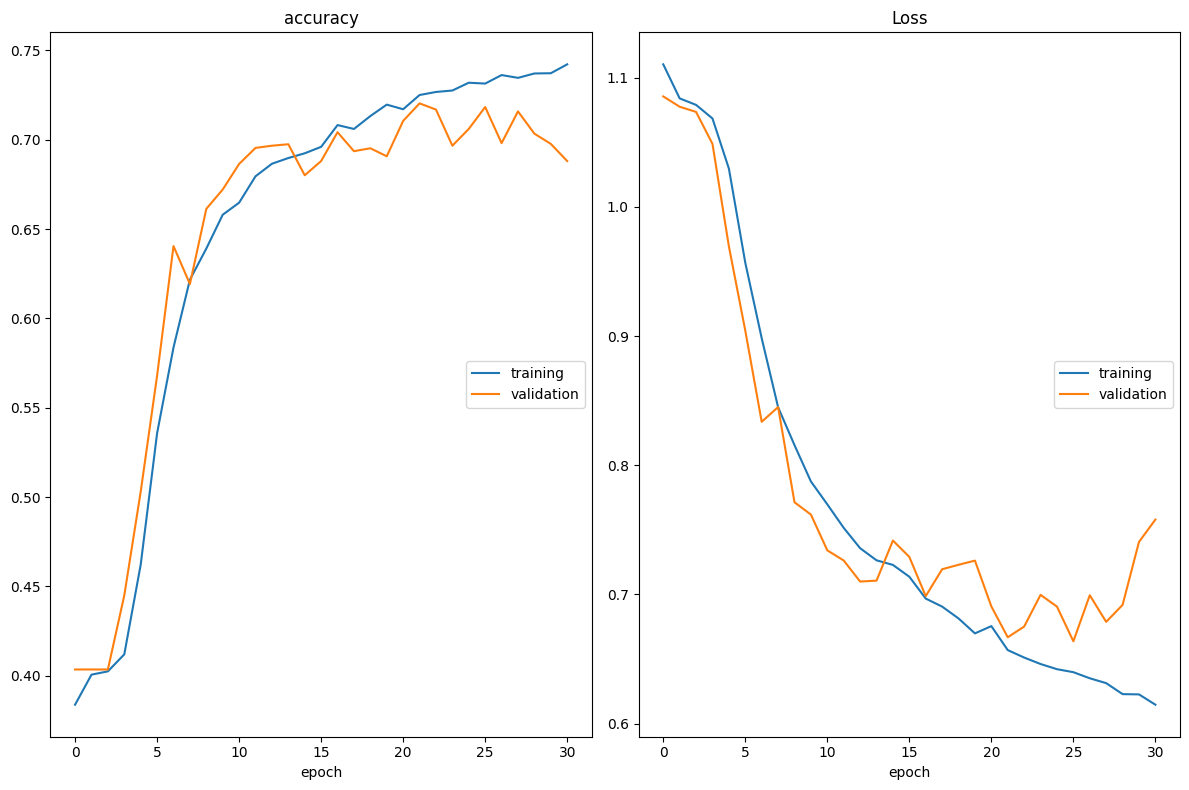

accuracy
	training         	 (min:    0.384, max:    0.742, cur:    0.742)
	validation       	 (min:    0.403, max:    0.720, cur:    0.688)
Loss
	training         	 (min:    0.615, max:    1.110, cur:    0.615)
	validation       	 (min:    0.664, max:    1.086, cur:    0.758)
459/459 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7370 - loss: 0.6188 - val_accuracy: 0.6880 - val_loss: 0.7580
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy en test:  0.7182839632277834
Negative Cross-Entropy (Log Loss): 0.6637535344878999


In [ ]:
# Aplicamos PCA
pca = PCA(n_components=0.9)
reduced_embeddings = pca.fit_transform(embedding_matrix) 

### Definición

embed_dim = reduced_embeddings.shape[1]
num_heads = 2  # Número de cabezas de atención
ff_dim = 32  # Tamaño de la capa densa en el bloque del transformer
rate = 0.3
maxlen = 70

inputs = layers.Input(shape=(maxlen,))
x =  GloveWithFixedPositionalEncoding(vocab_size, maxlen, reduced_embeddings)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x) # De aquí sale Z: una matriz donde cada fila es el vector de cada token enriquecido
x = layers.GlobalAveragePooling1D()(x) # Usamo GAP para reducir la dimensionalidad (Hace la media por filas) 
x = layers.Dropout(rate)(x)            # Otra opción: layers.flatten(), problema: aumenta mucho la dimensión
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(rate)(x)
outputs = layers.Dense(3, activation="softmax")(x) # Tendremos la probabilidad de cada una de las clases

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

### Entrenamiento

from livelossplot import PlotLossesKerasTF

model.compile(
    optimizer= keras.optimizers.AdamW(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Definir el callback de Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=5,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

history = model.fit(
    X_train_encoded, 
    y_train_encoded, 
    batch_size=32, 
    epochs=50, 
    validation_data=(X_test_encoded, y_test_encoded), 
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

### Evaluación

pred_probs = model.predict(X_test_encoded)
pred_class = ops.argmax(pred_probs,axis=1)
acc_test = ops.mean(pred_class == y_test_encoded)
acc_test = accuracy_score(y_test_encoded,pred_class)
log_loss_test = log_loss(y_test_encoded, pred_probs)

print("Accuracy en test: ", acc_test)
print("Cross-Entropy (Log Loss):", log_loss_test)


No conseguimos mejorar al modelo base, necesitamos un cambio drástico. Usar un encoder preentrenado!

# 3. Pretrained encoder

In [75]:
!pip install sentence_transformer

ERROR: Could not find a version that satisfies the requirement sentence_transformer (from versions: none)
ERROR: No matching distribution found for sentence_transformer


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# 1. Load sentence transformer (optimized for sentence embeddings)
model = SentenceTransformer('all-MiniLM-L6-v2')  # or 'all-mpnet-base-v2'

# 2. Encode your data
X_train_embeddings = model.encode(X_train, batch_size=32, show_progress_bar=True)
X_test_embeddings = model.encode(X_test, batch_size=32, show_progress_bar=True)

# 3. Encode labels if they're strings
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 4. Train a classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_embeddings, y_train_encoded)

# 5. Evaluate
y_pred = clf.predict(X_test_embeddings)

print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


# 4. ¿Por qué entrenar un modelo?

In [2]:
from googlesearch import search

def search_web(sentence, num_results=5):
    return list(search(sentence, num_results=num_results))

In [4]:
search_web("En un lugar de la mancha author")

['/search?num=7',
 'https://laspalabrasdescarriadas.es/2017/05/29/resena-un-lugar-de-la-mancha/',
 'https://comanegra.com/es/ficcion/180-en-un-lugar-de-la-mancha-.html',
 'https://www.amazon.es/Lugar-Mancha-Jordi-Vicente-R%C3%B3denas/dp/8416033323',
 'https://www.casadellibro.com/libro-en-un-lugar-de-la-mancha-don-quijote-en-verso/9788417103415/11342990?srsltid=AfmBOoqJO38fYcFbQI2BsaSYqGAWrK8GRESLRfaUiDQ8xzKRfQupKSuZ']

In [ ]:
def predict_author(sentence):
    # 1. Search online
    results = search_web(sentence)

    # 2. Extract content/snippets
    snippets = extract_snippets(results)

    # 3. Check for known author names or similarity to known texts
    author_score = score_authors(snippets)

    # 4. Return the most probable author
    return max(author_score, key=author_score.get)

In [ ]:
import requests
from bs4 import BeautifulSoup

def duckduckgo_search(query):
    url = f"https://html.duckduckgo.com/html?q={query}"
    headers = {"User-Agent": "Mozilla/5.0"}
    res = requests.get(url, headers=headers)
    soup = BeautifulSoup(res.text, 'html.parser')
    results = soup.find_all('a', {'class': 'result__a'})
    return [a.get_text() for a in results[:5]]

In [65]:
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizer

num_classes = 3  # e.g. number of authors
hidden_size = 768  # DistilBERT hidden size

distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
distilbert_model.trainable = False
input_ids = tf.keras.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int32, name='attention_mask')

def distilbert_encoder(inputs):
    input_ids, attention_mask = inputs
    outputs = distilbert_model(input_ids, attention_mask=attention_mask, return_dict=True)
    return outputs.last_hidden_state[:, 0, :]  # CLS token embedding

cls_embedding = tf.keras.layers.Lambda(distilbert_encoder, output_shape=(hidden_size,))([input_ids, attention_mask])

x = tf.keras.layers.Dense(256, activation='relu')(cls_embedding)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 768)       │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 256)       │    196,864 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 256)       │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 3)         │        771 │ dropout_28[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 197,635 (772.01 KB)

 Trainable params: 197,635 (772.01 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
from transformers import DistilBertTokenizer
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder


# Tokenizar los datasets
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

X_train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='tf')
X_test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='tf')

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  
y_test_encoded = le.transform(y_test)

y_train_tensor = tf.convert_to_tensor(y_train_encoded)
y_test_tensor = tf.convert_to_tensor(y_test_encoded)

In [67]:
# Create tf.dataa.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_train_encodings['input_ids'],
        'attention_mask': X_train_encodings['attention_mask']
    },
    y_train_tensor
)).shuffle(len(X_train_encodings)).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': X_test_encodings['input_ids'],
        'attention_mask': X_test_encodings['attention_mask']
    },
    y_test_tensor
)).batch(32).prefetch(tf.data.AUTOTUNE)

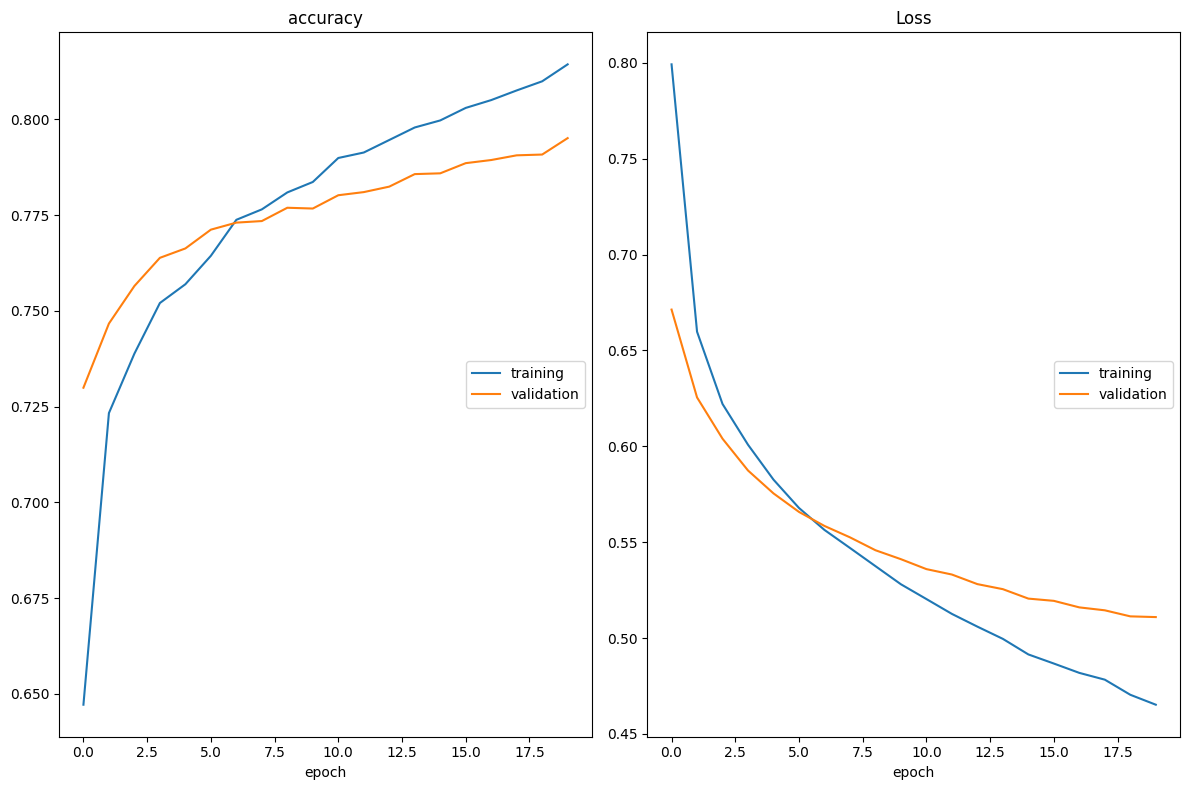

accuracy
	training         	 (min:    0.647, max:    0.814, cur:    0.814)
	validation       	 (min:    0.730, max:    0.795, cur:    0.795)
Loss
	training         	 (min:    0.465, max:    0.799, cur:    0.465)
	validation       	 (min:    0.511, max:    0.671, cur:    0.511)
459/459 ━━━━━━━━━━━━━━━━━━━━ 159s 346ms/step - accuracy: 0.8160 - loss: 0.4657 - val_accuracy: 0.7951 - val_loss: 0.5110


In [68]:
from livelossplot import PlotLossesKerasTF


# Definir el callback de Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=2,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

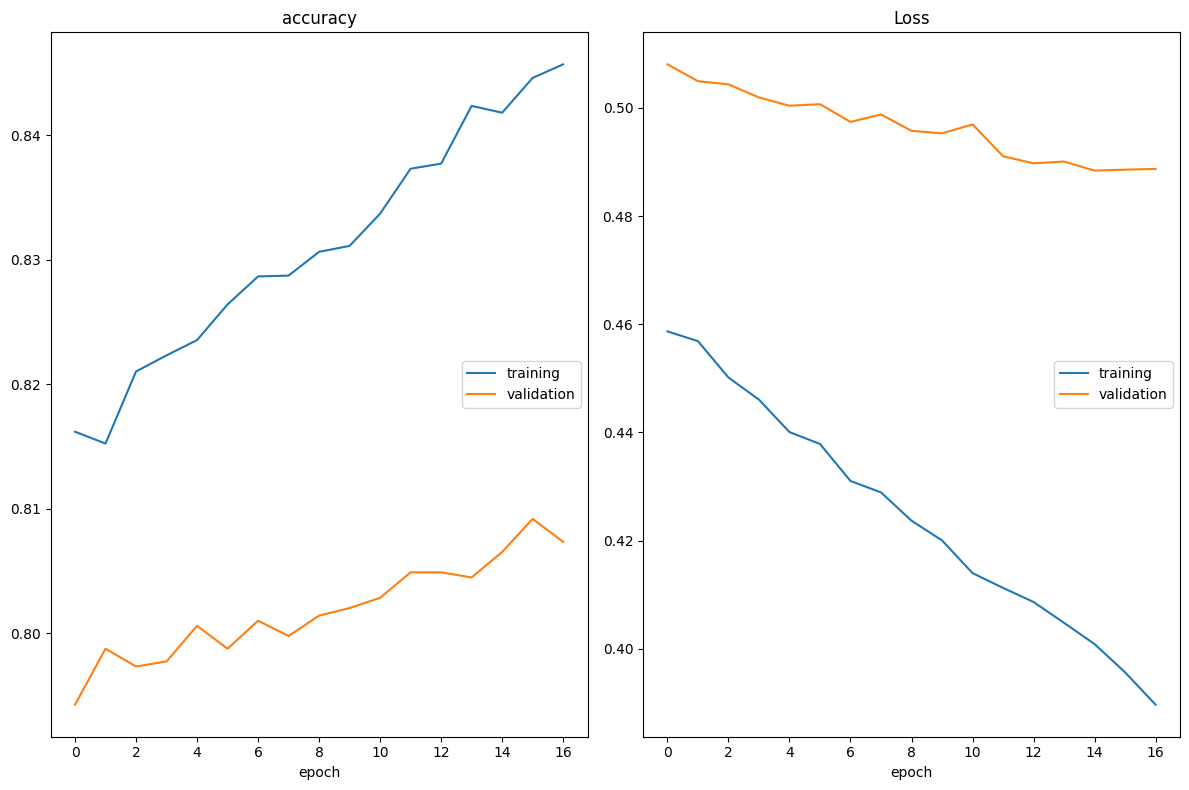

accuracy
	training         	 (min:    0.815, max:    0.846, cur:    0.846)
	validation       	 (min:    0.794, max:    0.809, cur:    0.807)
Loss
	training         	 (min:    0.390, max:    0.459, cur:    0.390)
	validation       	 (min:    0.488, max:    0.508, cur:    0.489)
459/459 ━━━━━━━━━━━━━━━━━━━━ 204s 444ms/step - accuracy: 0.8471 - loss: 0.3899 - val_accuracy: 0.8074 - val_loss: 0.4887


In [70]:
from livelossplot import PlotLossesKerasTF


# Definir el callback de Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=2,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

In [71]:
model.save("distibert_32b.h5")

In [72]:
### Evaluación

pred_probs = model.predict(val_dataset)
pred_class = ops.argmax(pred_probs,axis=1)
acc_test = ops.mean(pred_class == y_test_encoded)
acc_test = accuracy_score(y_test_encoded,pred_class)
log_loss_test = log_loss(y_test_encoded, pred_probs)

print("Accuracy en test: ", acc_test)
print("Cross-Entropy (Log Loss):", log_loss_test)

W0000 00:00:1748559143.472968   19923 assert_op.cc:38] Ignoring Assert operator functional_14_1/lambda_2_1/tf_distil_bert_model_2/distilbert/embeddings/assert_less/Assert/Assert


152/153 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step

W0000 00:00:1748559183.267057   19920 assert_op.cc:38] Ignoring Assert operator functional_14_1/lambda_2_1/tf_distil_bert_model_2/distilbert/embeddings/assert_less/Assert/Assert


153/153 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step
Accuracy en test:  0.8065372829417773
Cross-Entropy (Log Loss): 0.4884145449683454
